In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
from nilearn import image
import fsl.wrappers as fsl
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

In [3]:
nc = pd.read_csv('pair_cor_fdr.csv')
lda = pd.read_csv('../LDA_figure/lda_top56.csv').drop(columns='Unnamed: 0')

In [4]:
nc['measure'] = [i.split("_")[0] for i in nc['region']]
nc['measure'].replace({'zDCwei': 'DC', 'zfALFF': 'fALFF',
                       'gmd': 'GMV', 'zReHo': 'ReHo'}, inplace=True)
lda['measure'] = [i.split("-")[0] for i in lda['features']]
lda['measure'].replace({'gmv': 'GMV'}, inplace=True)

In [5]:
lda_ms = lda['measure'].unique()
nc_ms = nc['measure'].unique()
for lda_m in lda_ms:
    lda_g = lda[lda['measure']==lda_m]
    nc_g = nc[nc['measure']==lda_m]

In [6]:
lda['Section'] = [i.split("-")[1] for i in lda['features']]
nc['Section'] = 'cortex'

In [7]:
for j, i in enumerate(nc['region']):
    if i.find("17Networks")==-1:
        nc.iloc[j, nc.columns.get_loc('Section')] = 'subcortex'
    elif (i.find("17Networks_9")!=-1) or (i.find("17Networks_2")!=-1) or (i.find("17Networks_15")!=-1):
        nc.iloc[j, nc.columns.get_loc('Section')] = 'cerebellum'

In [8]:
lda['location'] = ["-".join(i.split("-")[2:]) for i in lda['features']]
nc['location'] = ["-".join(i.split("_")[1:]) for i in nc['region']]
lda['mask'] = ["_".join(i.split("-")[2:]) for i in lda['features']]
nc['mask'] = ["_".join(i.split("_")[1:]) for i in nc['region']]

In [9]:
lda['location'].replace({'17Networks-9': 'Network-9'},inplace=True)
nc['location'].replace({'17Networks-9': 'Network-9', '17Networks-2': 'Network-2'},inplace=True)
lda['mask'].replace({'17Networks_9': 'Network_9'},inplace=True)
nc['mask'].replace({'17Networks_9': 'Network_9', '17Networks_15': 'Network_15',
                    '17Networks_2': 'Network_2'},inplace=True)

In [10]:
for j, i in enumerate(nc['location']):
    if i.find("17Networks")!=-1:
        nc.iloc[j, nc.columns.get_loc('location')] = "-".join(i.split("-")[1:])

In [11]:
for loc in lda['location']:
    if loc not in nc['location'].values:
        print(loc)

In [30]:
new_index = nc.sws_total.abs().sort_values().index

In [33]:
new_index.values

array([ 71,   3,  90,   1,  10, 161, 176, 173, 181, 119,  51,  69,  30,
       130,  56,  67,  87, 183,  68, 165, 139,  93, 107, 157, 155,   2,
       149,  88, 132, 129, 124,   0, 120,  25, 135, 148, 154,  19, 145,
       142, 131, 103,  74, 127, 153, 178, 171,  61, 136, 146,  24, 137,
       126,   6, 104, 177, 172, 180, 160, 167, 152, 164, 133, 175,   4,
       112, 102, 123,  33, 110,  21,  54,  46, 151,  98, 144, 169,  76,
       140, 143,  80,  97,  39,  43,   8,  92, 174,  91,  78, 158,  42,
       109, 182,   5,  70,  28,  81, 159,  41, 163,  23,  15,  57,  94,
        96, 141,   9,  12,  50,  60, 128,  95,  77, 170,  55, 111,   7,
       134, 116, 147,  14,  59,  53, 166,  31,  47, 150,  20,  32,  64,
        83,  18,  29, 101,  79, 121, 105,  26,  27, 108,  37,  44, 138,
        62, 125, 179,  66,  89,  49,  52, 113,  58,  34,  84,  40, 117,
        36, 122,  82, 162, 118,  63,  45, 115,  75,  99, 100,  72,  11,
       168,  16,  22,  73,  85, 156,  35,  38,  65,  48,  17,  8

In [41]:
nc['sws_abs'] = np.abs(nc['sws_total'])
nc_ordered = nc.sort_values(by='sws_abs', ascending=False)
#nc_ordered = nc_ordered.iloc[::-1]
#nc_ordered
nc_ordered['features'] = nc_ordered['Section'] + '-' + nc_ordered['location']
nc_ordered.to_csv('nc_ordered.csv')

# Creating masks

In [12]:
sch_regions = pd.read_csv("../LDA_figure/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.Centroid_RAS.csv").set_index("ROI Name")
BN_regions = pd.read_csv('../LDA_figure/BN_Atlas_246_LUT_text.csv').set_index("ROI_Name")
Buck_regions = pd.read_csv('../LDA_figure/atl-Buckner17.csv').set_index('name')

In [13]:
for measure in nc['measure'].unique():
    print("Creating mask for {} measurement".format(measure))
    drc = "../nc_final_masks_Feb2/"+measure
    !mkdir $drc
    
    nc_measure = nc[nc['measure']==measure]
    for i, region in enumerate(nc_measure['mask']):
        section = nc_measure.iloc[i, nc_measure.columns.get_loc('Section')]
        if section == 'cortex':
            val = sch_regions.loc[[region], "ROI Label"].values[0]
            name = drc+'/'+region+'.nii.gz'
            imp = nc_measure.iloc[[i], nc_measure.columns.get_loc('sws_total')].values[0]
            fsl.fslmaths('../LDA_figure/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.nii').thr(val-0.1).uthr(val+0.1).run(name)
            fsl.fslmaths(name).bin().mul(imp).run(name)
        elif section == 'subcortex':
            val = BN_regions.loc[[region], "Value"].values[0]
            name = drc+'/'+region+'.nii.gz'
            imp = nc_measure.iloc[[i], nc_measure.columns.get_loc('sws_total')].values[0]
            fsl.fslmaths('../LDA_figure/BN_Atlas_246_2mm.nii.gz').thr(val-0.1).uthr(val+0.1).run(name)
            fsl.fslmaths(name).bin().mul(imp).run(name)
        else:
            #val = Buck_regions.loc[[region], "index"].values[0]
            name = drc+'/'+region+'.nii.gz'
            imp = nc_measure.iloc[[i], nc_measure.columns.get_loc('sws_total')].values[0]
            #fsl.fslmaths('../LDA_figure/atl-Buckner17_space-MNI_dseg.nii').thr(val-0.1).uthr(val+0.1).run(name)
            fsl.fslmaths(name).bin().mul(imp).run(name)
    regs = os.listdir(drc)
    for i, reg in enumerate(regs):
        if i != 0:
            source = image.load_img(drc+"/"+measure+".nii.gz")
        reg_img = image.load_img(drc+"/"+reg)
        if i == 0:
            source = reg_img
        fsl.fslmaths(source).add(reg_img).run(drc+"/"+measure+".nii.gz")  

Creating mask for fALFF measurement
mkdir: cannot create directory ‘../nc_final_masks_Feb2/fALFF’: File exists
Creating mask for GMV measurement
mkdir: cannot create directory ‘../nc_final_masks_Feb2/GMV’: File exists
Creating mask for ReHo measurement
mkdir: cannot create directory ‘../nc_final_masks_Feb2/ReHo’: File exists
Creating mask for DC measurement
mkdir: cannot create directory ‘../nc_final_masks_Feb2/DC’: File exists


In [14]:
for i, mask in enumerate(lda['mask']):
    if lda.iloc[[i], lda.columns.get_loc('Section')].values[0] == 'cortex':
        lda.iloc[[i], lda.columns.get_loc('mask')] = '17Networks_'+mask

In [15]:
for measure in lda['measure'].unique():
    print("Creating mask for {} measurement".format(measure))
    drc = "../lda_final_masks_Feb2/"+measure
    !mkdir $drc
    
    lda_measure = lda[lda['measure']==measure]
    for i, region in enumerate(lda_measure['mask']):
        section = lda_measure.iloc[i, lda_measure.columns.get_loc('Section')]
        if section == 'cortex':
            val = sch_regions.loc[[region], "ROI Label"].values[0]
            name = drc+'/'+region+'.nii.gz'
            imp = lda_measure.iloc[[i], lda_measure.columns.get_loc('LD1')].values[0]
            fsl.fslmaths('../LDA_figure/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.nii').thr(val-0.1).uthr(val+0.1).run(name)
            fsl.fslmaths(name).bin().mul(imp).run(name)
        elif section == 'subcortex':
            val = BN_regions.loc[[region], "Value"].values[0]
            name = drc+'/'+region+'.nii.gz'
            imp = lda_measure.iloc[[i], lda_measure.columns.get_loc('LD1')].values[0]
            fsl.fslmaths('../LDA_figure/BN_Atlas_246_2mm.nii.gz').thr(val-0.1).uthr(val+0.1).run(name)
            fsl.fslmaths(name).bin().mul(imp).run(name)
        else:
            #val = Buck_regions.loc[[region], "index"].values[0]
            name = drc+'/'+region+'.nii.gz'
            imp = lda_measure.iloc[[i], lda_measure.columns.get_loc('LD1')].values[0]
            #fsl.fslmaths('../LDA_figure/atl-Buckner17_space-MNI_dseg.nii').thr(val-0.1).uthr(val+0.1).run(name)
            fsl.fslmaths(name).bin().mul(imp).run(name)
    regs = os.listdir(drc)
    for i, reg in enumerate(regs):
        if i != 0:
            source = image.load_img(drc+"/"+measure+".nii.gz")
        reg_img = image.load_img(drc+"/"+reg)
        if i == 0:
            source = reg_img
        fsl.fslmaths(source).add(reg_img).run(drc+"/"+measure+".nii.gz")  

Creating mask for GMV measurement
mkdir: cannot create directory ‘../lda_final_masks_Feb2/GMV’: File exists
Creating mask for DC measurement
mkdir: cannot create directory ‘../lda_final_masks_Feb2/DC’: File exists
Creating mask for fALFF measurement
mkdir: cannot create directory ‘../lda_final_masks_Feb2/fALFF’: File exists


# creating barplot

In [16]:
lda['y_ax'] = lda['Section'] + '-' + lda['location']
lda.head()

,features,LD1,measure,Section,location,mask,y_ax
0,gmv-cortex-LH-LimbicB-OFC-1,8.264456,GMV,cortex,LH-LimbicB-OFC-1,17Networks_LH_LimbicB_OFC_1,cortex-LH-LimbicB-OFC-1
1,gmv-cortex-RH-VisCent-ExStr-8,6.316778,GMV,cortex,RH-VisCent-ExStr-8,17Networks_RH_VisCent_ExStr_8,cortex-RH-VisCent-ExStr-8
2,DC-cortex-LH-DorsAttnB-PostC-1,4.472864,DC,cortex,LH-DorsAttnB-PostC-1,17Networks_LH_DorsAttnB_PostC_1,cortex-LH-DorsAttnB-PostC-1
3,DC-cortex-LH-SalVentAttnA-FrMed-1,-4.052401,DC,cortex,LH-SalVentAttnA-FrMed-1,17Networks_LH_SalVentAttnA_FrMed_1,cortex-LH-SalVentAttnA-FrMed-1
4,gmv-cortex-RH-SomMotA-10,3.992222,GMV,cortex,RH-SomMotA-10,17Networks_RH_SomMotA_10,cortex-RH-SomMotA-10


- lda_falff

In [17]:
lda_falff = lda[lda['measure']=='fALFF']
lda_falff_fig = lda_falff[['y_ax', 'LD1', 'LD1']].set_index('y_ax')
lda_falff_fig.head()

,LD1,LD1
y_ax,,
subcortex-cTtha-L,3.210250,3.210250
cortex-LH-SomMotB-Aud-4,2.725182,2.725182
cortex-LH-SomMotB-S2-2,2.456045,2.456045
cortex-RH-SalVentAttnA-FrMed-2,2.440729,2.440729
cortex-LH-DorsAttnB-PostC-5,-2.293910,-2.293910


In [26]:
font = {'family': 'sans',
       'weight': 'normal',
       'size': 18}
rc('font', **font)

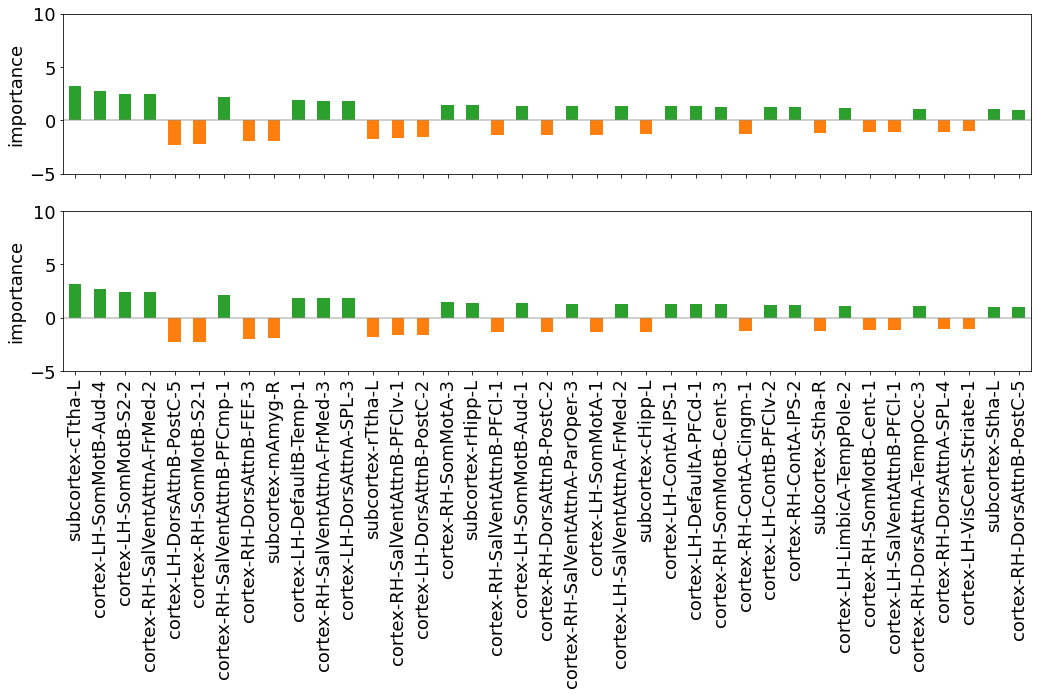

In [34]:
maxPC = 1.01 * np.max(np.max(np.abs(lda_falff_fig.iloc[0:5, :])))
f, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = lda_falff_fig.iloc[:, i]
    colors = ['C2' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#8888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'importance')
    ax.set_xlabel(f'')
    ax.set_ylim(-5, 10)
plt.tight_layout()
plt.savefig('LDA_falff_FeatureImportance.jpg')
plt.show()

- lda_dc

In [35]:
lda_dc = lda[lda['measure']=='DC']
lda_dc_fig = lda_dc[['y_ax', 'LD1', 'LD1']].set_index('y_ax')
lda_dc_fig.head()

,LD1,LD1
y_ax,,
cortex-LH-DorsAttnB-PostC-1,4.472864,4.472864
cortex-LH-SalVentAttnA-FrMed-1,-4.052401,-4.052401
cortex-RH-SalVentAttnA-ParOper-1,2.961035,2.961035
cortex-LH-SalVentAttnA-ParOper-1,-2.393801,-2.393801
cortex-RH-SalVentAttnA-ParMed-4,-2.268095,-2.268095


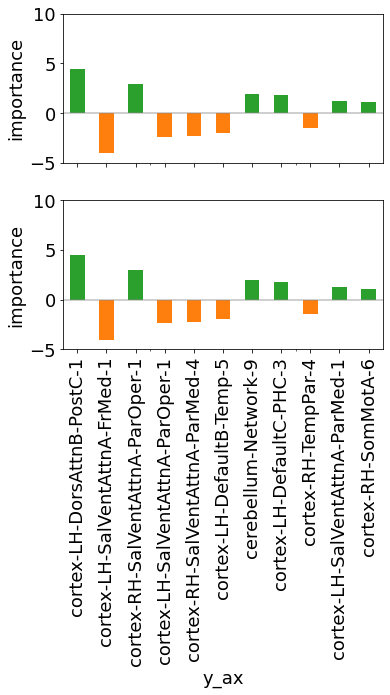

In [44]:
maxPC = 1.01 * np.max(np.max(np.abs(lda_dc_fig.iloc[0:5, :])))
f, axes = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = lda_dc_fig.iloc[:, i]
    colors = ['C2' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#8888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'importance')
    ax.set_ylim(-5, 10)
plt.tight_layout()
plt.savefig('LDA_dc_FeatureImportance.jpg')
plt.show()

- lda-gmv

In [38]:
lda_gmv = lda[lda['measure']=='GMV']
lda_gmv_fig = lda_gmv[['y_ax', 'LD1', 'LD1']].set_index('y_ax')
lda_gmv_fig.head()

,LD1,LD1
y_ax,,
cortex-LH-LimbicB-OFC-1,8.264456,8.264456
cortex-RH-VisCent-ExStr-8,6.316778,6.316778
cortex-RH-SomMotA-10,3.992222,3.992222
subcortex-lPFtha-R,3.837399,3.837399
cortex-LH-DorsAttnB-PostC-6,-3.249644,-3.249644


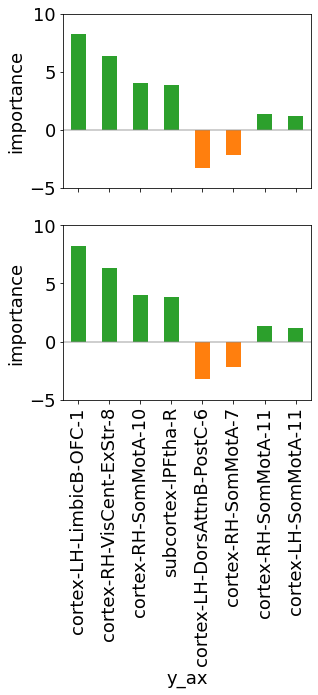

In [43]:
maxPC = 1.01 * np.max(np.max(np.abs(lda_gmv_fig.iloc[0:5, :])))
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = lda_gmv_fig.iloc[:, i]
    colors = ['C2' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#8888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'importance')
    ax.set_ylim(-5, 10)
plt.tight_layout()
plt.savefig('LDA_gmv_FeatureImportance.jpg')
plt.show()